## Helper Functions

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools as it
%matplotlib inline

# plots an array of images into an image matrix
def plot_image_array(images, titles = [], ncols = 2, nrows = -1, fig_width = 20, fig_row_height = 4.5):
    if nrows <= 0:
        nrows = math.ceil(len(images) / 2)
    fig = plt.figure(figsize=(fig_width, nrows * fig_row_height))
    for idx, img in enumerate(images):
        if idx >= (nrows * ncols):
            break
        a=fig.add_subplot(nrows, ncols, idx + 1)
        if len(img.shape) == 2:
            imgplot = plt.imshow(img, cmap = 'gray' if len(img.shape) == 2 else None)
        else:
            imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))     
        if(len(titles) >= idx):
            a.set_title(titles[idx])
            
# saves an array of images to a folder         
def save_images(folder, images, names):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for img, fname in zip(images, names):
        fname = fname.replace('/', '_')
        fname = fname.replace(' ', '_')
        fname = fname.replace(':', '_')
        fname = fname.replace('.jpg', '')
        p = os.path.join(folder, os.path.split(fname)[-1])

        p += '.jpg'
        if np.max(img) == 1:
            img = img * 255
        #print('saving', p)
        cv2.imwrite(p, img)
        
def create_image_transforms(img, trans, arg_map, create_titles = True, base_title = "", add_original = True):
    out = []
    titles = []
    if add_original:
        out.append(img)
        titles.append(base_title)
        
        keys = sorted(arg_map)
        arg_combinations = it.product(*(arg_map[k] for k in keys))
        
        for args in arg_combinations:
            a = dict(zip(keys, args))
            out.append(trans(img, **a))
            title = base_title
            for k in a.keys():
                title += '_' + k + '=' + str(a[k])
            titles.append(title)
            
    if create_titles:
        return out, titles
    else:
        return out
        


## Import Training Data

In [3]:
import glob
import matplotlib.image as mpimg
import os

loc_vehicles = './training_data/vehicles'
loc_non_vehicles = './training_data/non-vehicles'

# reurns a dictionary with an entry for each subfolder of folder 
# and a list with all image files for each category
def load_training_dictionary(folder):
    result = {}
    num_samples = 0
    categories = [dI for dI in os.listdir(folder) if os.path.isdir(os.path.join(folder, dI))]
    for c in categories:
        image_files = glob.glob(os.path.normpath(os.path.join(folder, c, 'image*.png')))
        num_samples += len(image_files)
        result[c] = image_files
        
    return result, num_samples
     

dict_vehicles, num_vehicles = load_training_dictionary(loc_vehicles)
print(num_vehicles, 'samples loaded from', loc_vehicles)
dict_non_vehicles, num_non_vehicles = load_training_dictionary(loc_non_vehicles)
print(num_non_vehicles, 'samples loaded from', loc_non_vehicles)



3002 samples loaded from ./training_data/vehicles
3900 samples loaded from ./training_data/non-vehicles


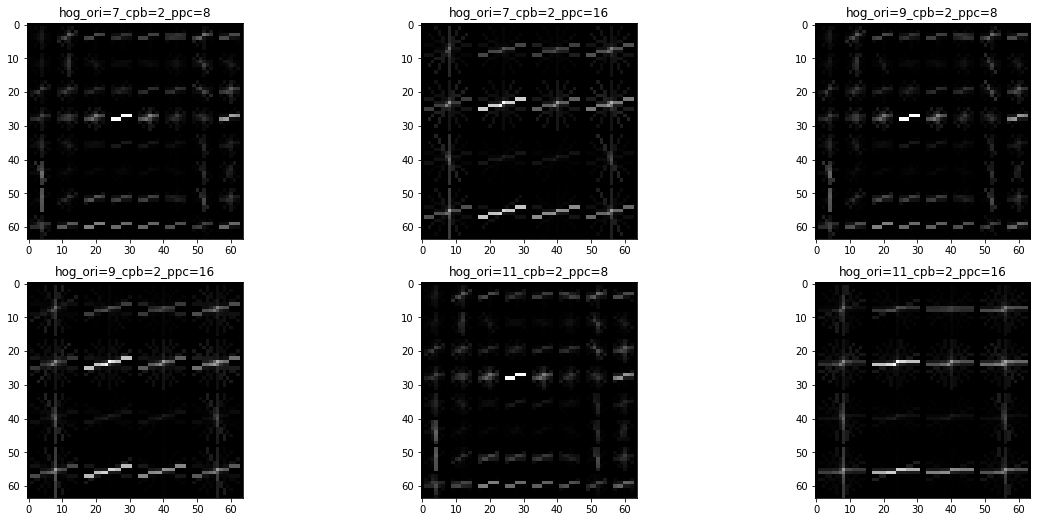

In [25]:
from skimage.feature import hog
import cv2 

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                              visualise=True, feature_vector=False)
    return features, hog_image


test_file = dict_vehicles['GTI_MiddleClose'][0]
test_img = mpimg.imread(test_file)
test_img = np.uint8(test_img*255)
ytest_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2YCrCb)

gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 3
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

args = {'ori': [7, 9, 11], 'ppc': [8, 16], 'cpb': [2]}
def hog_transform(img, ori, ppc, cpb):
    _, result = get_hog_features(img, ori, ppc, cpb, vis=True, feature_vec=False)
    return result

o, t = create_image_transforms(gray, hog_transform, args, base_title='hog')

plot_image_array(o[1:], t[1:], ncols=3)
save_images('output_images', o, t)

        




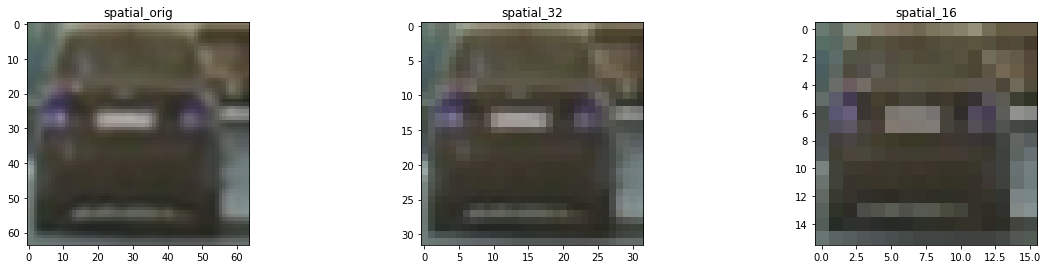

In [22]:
o = [test_img]
t = ['spatial_orig']

o.append(cv2.resize(test_img, (32, 32)))
t.append("spatial_32")
o.append(cv2.resize(test_img, (16, 16)))
t.append("spatial_16")

plot_image_array(o, t, ncols=3)
save_images('output_images', o, t)

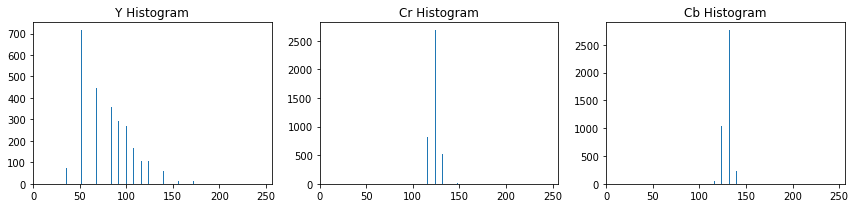

In [23]:
# Define a function to compute color histogram features  

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(ytest_img, nbins=32, bins_range=(0, 256))
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('Cr Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('Cb Histogram')
    fig.tight_layout()